In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os

In [2]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68606236/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


In [5]:
class_names = train_dataset.class_names

In [6]:
class_names

['cats', 'dogs']

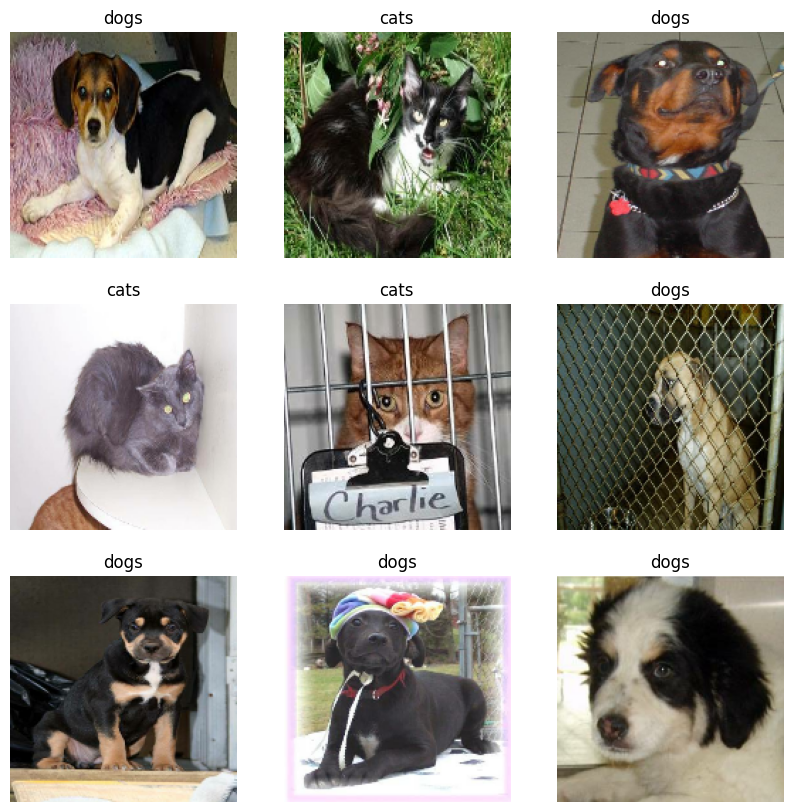

In [7]:
plt.figure(figsize=(10 , 10))
for images , labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot( 3 , 3 , i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)

In [9]:
print(val_batches)

tf.Tensor(32, shape=(), dtype=int64)


In [10]:
test_dataset = validation_dataset.take(val_batches // 5 )
validation_dataset = validation_dataset.skip(val_batches // 5)

In [11]:
#Buffered Prefetching

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size  = AUTOTUNE)

In [13]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

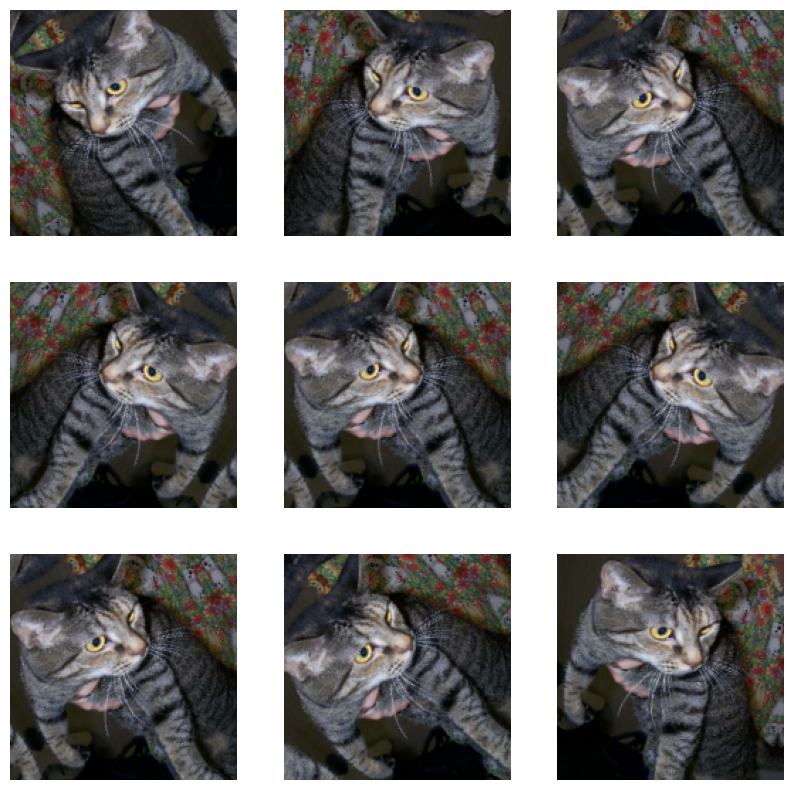

In [14]:
for image , _ in train_dataset.take(1):
  plt.figure(figsize=(10 , 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3 , 3 , i +1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0]/255)
    plt.axis("Off")

In [15]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

#rescale = tf.keras.layers.Rescaling(1./127.5 , offset = -1)

In [16]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE , include_top = False, weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [17]:
image_batch , label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 1280])

Feature Extractor

In [18]:
base_model.trainable = False

In [19]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [21]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [22]:
inputs = tf.keras.Input(shape = (160 , 160 ,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x , training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0,2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model( inputs , outputs)

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [24]:
len(model.trainable_variables)

2

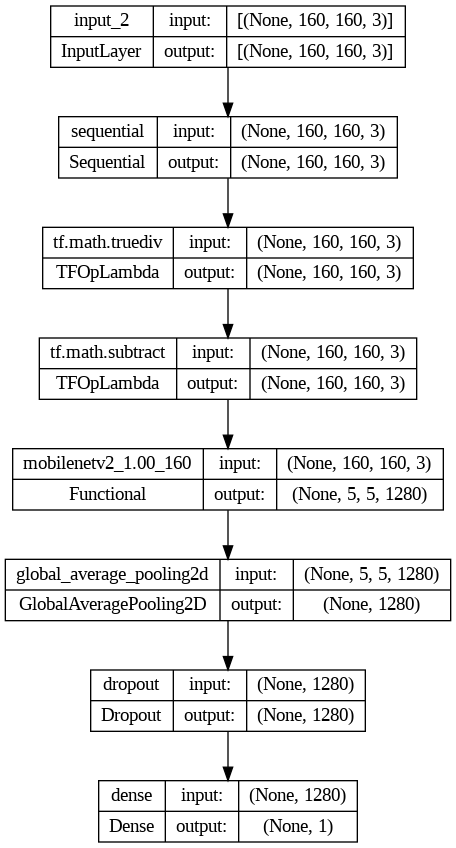

In [25]:
tf.keras.utils.plot_model(model , show_shapes=True)

In [26]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0 , name='accuracy')])

In [27]:
initial_epochs = 10

In [28]:
loss0 , accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 33s 1s/step - loss: 0.8650 - accuracy: 0.4158


In [29]:
history = model.fit(train_dataset , epochs = initial_epochs , validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 117s 2s/step - loss: 0.7261 - accuracy: 0.5535 - val_loss: 0.5581 - val_accuracy: 0.7252
Epoch 2/10
63/63 [==============================] - 93s 1s/step - loss: 0.5195 - accuracy: 0.7630 - val_loss: 0.3992 - val_accuracy: 0.8837
Epoch 3/10
63/63 [==============================] - 74s 1s/step - loss: 0.4044 - accuracy: 0.8435 - val_loss: 0.3019 - val_accuracy: 0.9307
Epoch 4/10
63/63 [==============================] - 76s 1s/step - loss: 0.3347 - accuracy: 0.8805 - val_loss: 0.2433 - val_accuracy: 0.9468
Epoch 5/10
63/63 [==============================] - 67s 1s/step - loss: 0.2932 - accuracy: 0.9025 - val_loss: 0.2082 - val_accuracy: 0.9592
Epoch 6/10
63/63 [==============================] - 71s 1s/step - loss: 0.2559 - accuracy: 0.9135 - val_loss: 0.1832 - val_accuracy: 0.9653
Epoch 7/10
63/63 [==============================] - 67s 1s/step - loss: 0.2414 - accuracy: 0.9180 - val_loss: 0.1662 - val_accuracy: 0.9666
Epoch 8/10
63/63 [=

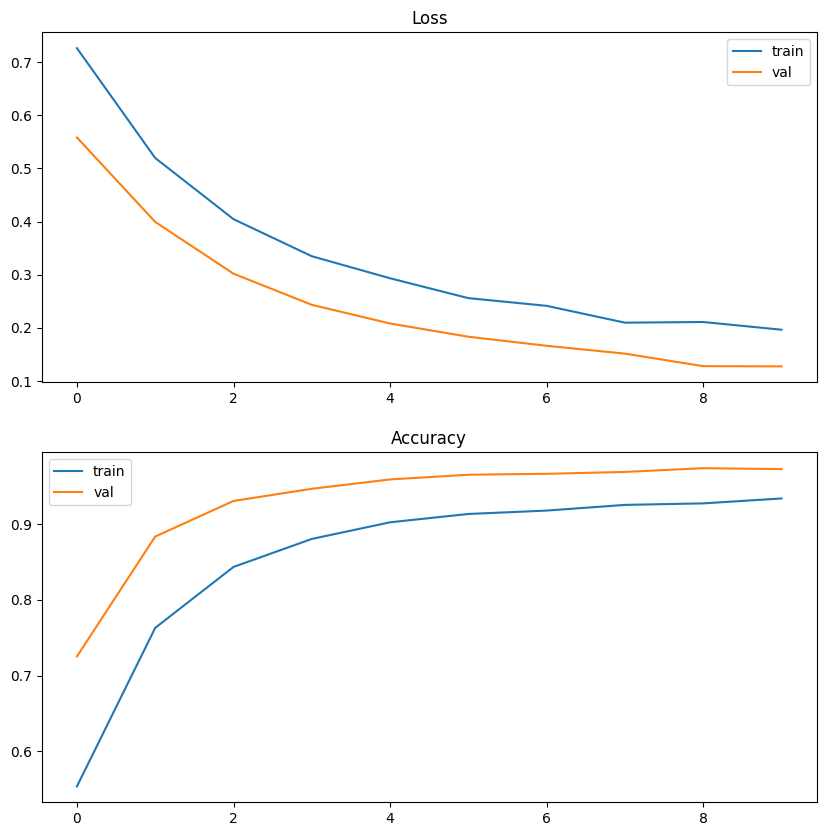

In [32]:
plt.figure(figsize=(10 , 10))
plt.subplot(211)
plt.title("Loss")
plt.plot(history.history['loss'] , label = 'train')
plt.plot(history.history['val_loss'] , label = 'val')
plt.legend()

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history['accuracy'] , label = 'train')
plt.plot(history.history['val_accuracy'] , label = 'val')
plt.legend()

In [33]:
model.evaluate(test_dataset)

6/6 [==============================] - 13s 2s/step - loss: 0.1324 - accuracy: 0.9635


[0.13237124681472778, 0.9635416865348816]

FINE TUNING

In [34]:
base_model.trainable = True

In [35]:
len(base_model.layers)

154

In [36]:
fine_tune_at = 100

In [37]:
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [38]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics = [tf.keras.metrics.BinaryAccuracy(threshold=0 , name='accuracy')])

In [39]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [41]:
len(model.trainable_variables)

56

In [42]:
fine_tune_epochs = 10

In [44]:
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs = total_epochs,
                         initial_epoch = history.epoch[-1],
                         validation_data = validation_dataset)

Epoch 10/20
63/63 [==============================] - 163s 2s/step - loss: 0.1420 - accuracy: 0.9460 - val_loss: 0.0477 - val_accuracy: 0.9851
Epoch 11/20
63/63 [==============================] - 103s 2s/step - loss: 0.1061 - accuracy: 0.9585 - val_loss: 0.0440 - val_accuracy: 0.9876
Epoch 12/20
63/63 [==============================] - 159s 3s/step - loss: 0.0891 - accuracy: 0.9645 - val_loss: 0.0462 - val_accuracy: 0.9851
Epoch 13/20
63/63 [==============================] - 99s 2s/step - loss: 0.0766 - accuracy: 0.9700 - val_loss: 0.0451 - val_accuracy: 0.9827
Epoch 14/20
63/63 [==============================] - 103s 2s/step - loss: 0.0709 - accuracy: 0.9740 - val_loss: 0.0374 - val_accuracy: 0.9864
Epoch 15/20
63/63 [==============================] - 105s 2s/step - loss: 0.0654 - accuracy: 0.9755 - val_loss: 0.0295 - val_accuracy: 0.9876
Epoch 16/20
63/63 [==============================] - 98s 2s/step - loss: 0.0634 - accuracy: 0.9750 - val_loss: 0.0394 - val_accuracy: 0.9901
Epoch 17

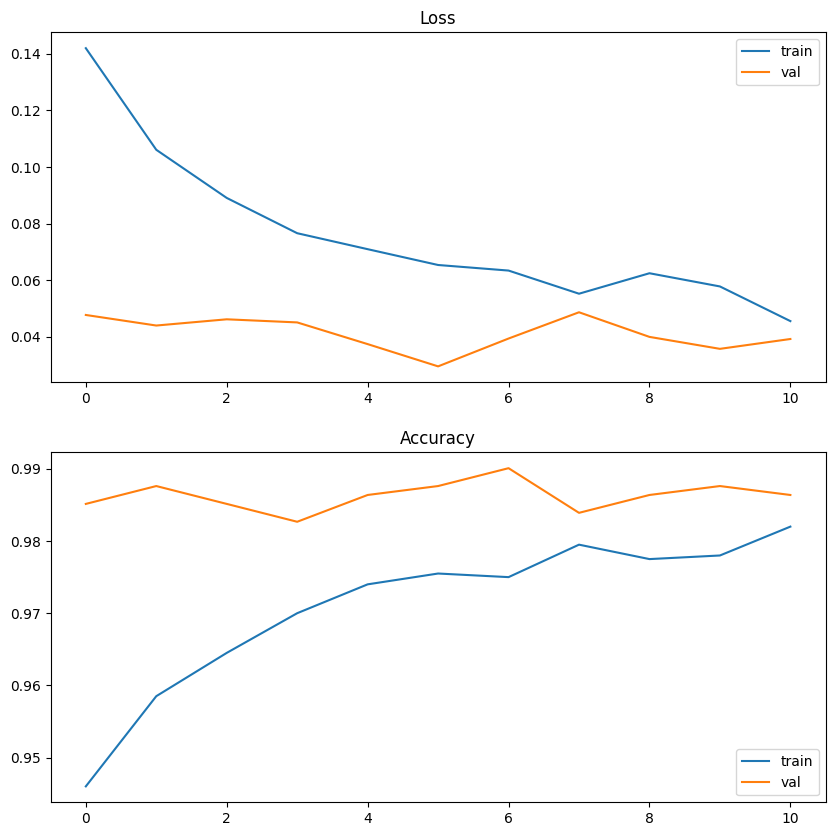

In [45]:
plt.figure(figsize=(10 , 10))
plt.subplot(211)
plt.title("Loss")
plt.plot(history_fine.history['loss'] , label ='train')
plt.plot(history_fine.history['val_loss'] , label = 'val')
plt.legend()

plt.subplot(212)
plt.title('Accuracy')
plt.plot(history_fine.history['accuracy'] , label = 'train')
plt.plot(history_fine.history['val_accuracy'] , label = 'val')
plt.legend()

In [46]:
model.evaluate(test_dataset)

6/6 [==============================] - 7s 1s/step - loss: 0.0678 - accuracy: 0.9844


[0.06780338287353516, 0.984375]

In [52]:
image_batch , label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

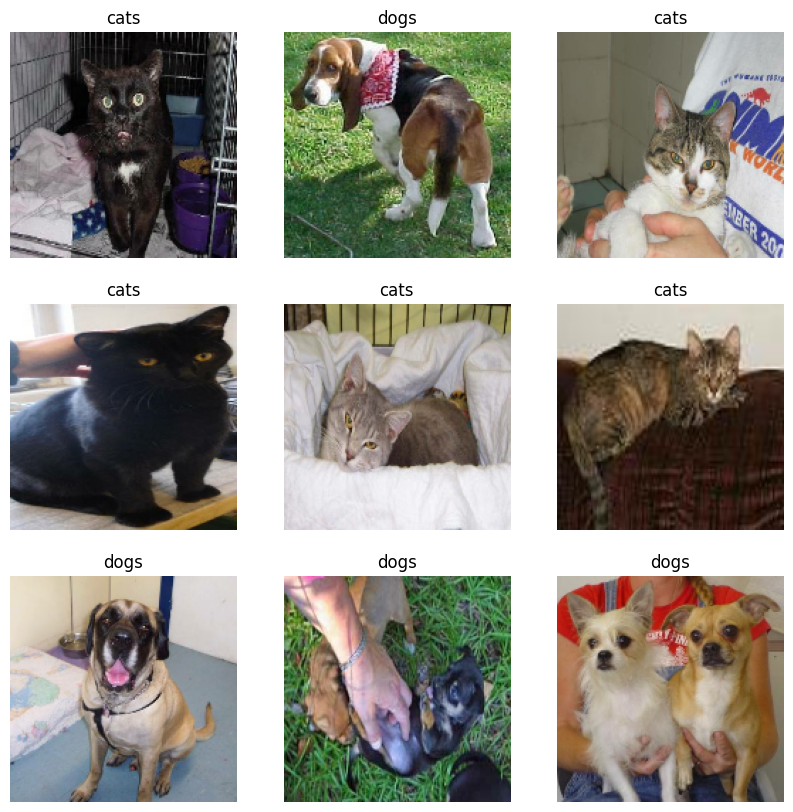

In [53]:
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5 , 0 , 1)

plt.figure(figsize = (10 , 10))
for i in range(9):
  ax = plt.subplot(3 , 3, i+1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")